1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
2. Повторить п.2, но используя уже не медиану, а max
3. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
4. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import numpy as np
import pandas as pd

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

--2022-03-03 11:32:26--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 108.177.11.139, 108.177.11.101, 108.177.11.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.11.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4sph35njl63q0an0netbo8np43lnl5qj/1646307075000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download [following]
--2022-03-03 11:32:26--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4sph35njl63q0an0netbo8np43lnl5qj/1646307075000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2022-03-03 11:33:03--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Resolving drive.google.com (drive.google.com)... 173.194.215.102, 173.194.215.101, 173.194.215.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/50kvteb8p0p80qq2imhkd484orst5vq7/1646307150000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download [following]
--2022-03-03 11:33:04--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/50kvteb8p0p80qq2imhkd484orst5vq7/1646307150000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c12::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-04-c0

In [5]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")

In [7]:
!pip install razdel pymorphy2 pyLDAvis

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 1.7 MB 10.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.2 MB 31.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=386214111e8bc9d0cf31af6fa53dc57fa2a367f13338766a8f3f80adbbc49227
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [8]:
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize
import pymorphy2

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stopword_ru = stopwords.words('russian')

In [12]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2022-03-03 11:35:36--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 173.194.215.101, 173.194.215.139, 173.194.215.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ochu0tnjptaobamnm0v6mmopmi7si339/1646307300000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download [following]
--2022-03-03 11:35:36--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ochu0tnjptaobamnm0v6mmopmi7si339/1646307300000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0

In [15]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords

In [14]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [19]:
morph = pymorphy2.MorphAnalyzer()

In [18]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/27000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Possible nested set at position 39
  
100%|██████████| 27000/27000 [00:31<00:00, 868.74it/s] 

CPU times: user 27.7 s, sys: 1.6 s, total: 29.3 s
Wall time: 31.2 s


In [20]:
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [03:44<00:00, 120.37it/s]


In [21]:
texts = list(news['title'].values)

common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [22]:
N_topic = 20

In [24]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=5)

CPU times: user 3min 53s, sys: 1min 56s, total: 5min 50s
Wall time: 3min 45s


In [25]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [26]:
lda = LdaModel.load(temp_file)

In [27]:
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.12895304),
 (3, 0.29680157),
 (4, 0.030938322),
 (11, 0.09595444),
 (12, 0.4026152),
 (14, 0.029843792)]

In [28]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [29]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 41.9 s, sys: 22.5 s, total: 1min 4s
Wall time: 39.7 s


In [30]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [31]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [32]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.02085553, 0.03736411, 0.01763673, 0.12720959, 0.03141768,
       0.        , 0.0101233 , 0.        , 0.23851492, 0.10837335,
       0.0328765 , 0.01971679, 0.00323271, 0.        , 0.14064718,
       0.13745211, 0.00253148, 0.04769173, 0.        , 0.01172741])

In [33]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 683 ms, sys: 7.41 ms, total: 690 ms
Wall time: 745 ms


In [34]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2022-03-03 11:56:00--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 173.194.215.101, 173.194.215.139, 173.194.215.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1c5hq4kj3l7bu0cb32noeu0dsfmvuguh/1646308500000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download [following]
--2022-03-03 11:56:00--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1c5hq4kj3l7bu0cb32noeu0dsfmvuguh/1646308500000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0k-c0-docs.googleusercontent.com (doc-0k-c0

In [35]:
target = pd.read_csv("users_churn.csv")

In [36]:
X = pd.merge(user_embeddings, target, 'left')

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [39]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
preds = logreg.predict_proba(X_test)[:, 1]

In [41]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.31651772918168836, F-Score=0.765, Precision=0.780, Recall=0.751


In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1703   52]
 [  62  183]]


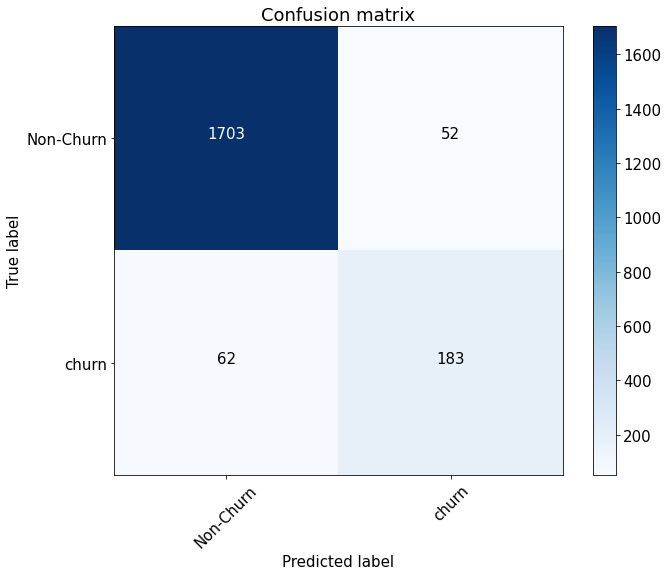

In [45]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [48]:
roc_auc = roc_auc_score(y_test, preds)

In [49]:
metrics = pd.Series({'precision': precision[ix],
                     'recall': recall[ix],
                     'f1_score': fscore[ix],
                     'roc_auc': roc_auc
                    }).to_frame().T
metrics

,precision,recall,f1_score,roc_auc
0,0.779661,0.75102,0.765073,0.970028


In [51]:
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # можно не среднее
    return user_vector

In [52]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding_median(user_articles_list, doc_dict)

array([0.        , 0.        , 0.        , 0.11519777, 0.        ,
       0.        , 0.        , 0.        , 0.07400792, 0.07381636,
       0.        , 0.01176036, 0.        , 0.        , 0.0739125 ,
       0.08209564, 0.        , 0.        , 0.        , 0.        ])

In [53]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 1.31 s, sys: 18.7 ms, total: 1.33 s
Wall time: 1.4 s


In [54]:
X = pd.merge(user_embeddings, target, 'left')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [56]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [57]:
preds = logreg.predict_proba(X_test)[:, 1]

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}') 

Best Threshold=0.3057453293181726, F-Score=0.785, Precision=0.821, Recall=0.751


Confusion matrix, without normalization
[[1715   40]
 [  62  183]]


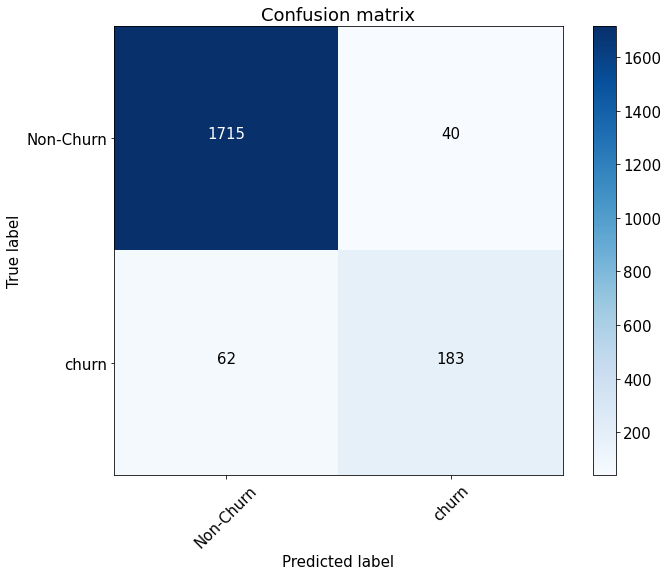

In [59]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [60]:
roc_auc_median = roc_auc_score(y_test, preds)

In [61]:
metrics_median = pd.Series({'precision': precision[ix],
                     'recall': recall[ix],
                     'f1_score': fscore[ix],
                     'roc_auc': roc_auc
                    }).to_frame().T
metrics = metrics.append(metrics_median, ignore_index=True)
metrics

,precision,recall,f1_score,roc_auc
0,0.779661,0.75102,0.765073,0.970028
1,0.821429,0.75102,0.784648,0.970028


In [62]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # можно не среднее
    return user_vector

In [63]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding_max(user_articles_list, doc_dict)

array([0.12513317, 0.22418466, 0.08376424, 0.29054973, 0.15534922,
       0.        , 0.0607398 , 0.        , 0.87089878, 0.29264978,
       0.19725902, 0.06506401, 0.01939624, 0.        , 0.39293849,
       0.50501806, 0.01518886, 0.20617206, 0.        , 0.07036448])

In [64]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 554 ms, sys: 12.5 ms, total: 567 ms
Wall time: 654 ms


In [65]:
X = pd.merge(user_embeddings, target, 'left')

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [67]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [68]:
preds = logreg.predict_proba(X_test)[:, 1]

In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}') 

Best Threshold=0.41283085199758596, F-Score=0.730, Precision=0.769, Recall=0.694


Confusion matrix, without normalization
[[1704   51]
 [  76  169]]


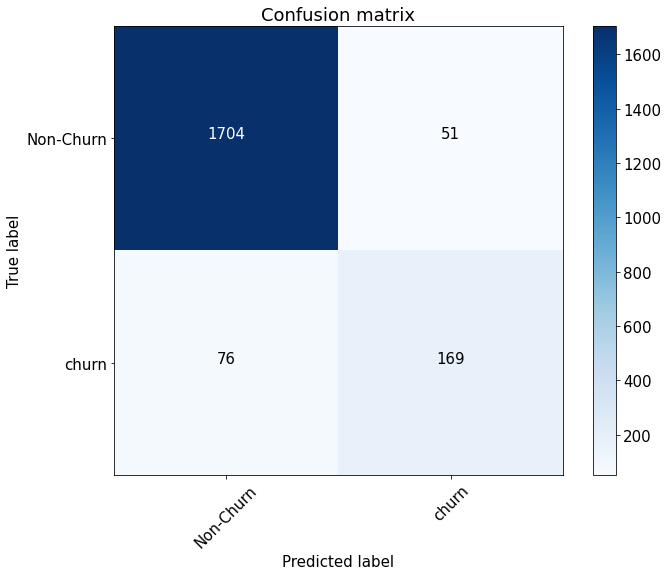

In [70]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [71]:
roc_auc_max = roc_auc_score(y_test, preds)

In [72]:
metrics_max = pd.Series({'precision': precision[ix],
                     'recall': recall[ix],
                     'f1_score': fscore[ix],
                     'roc_auc': roc_auc
                    }).to_frame().T
metrics = metrics.append(metrics_max, ignore_index=True)
metrics

,precision,recall,f1_score,roc_auc
0,0.779661,0.751020,0.765073,0.970028
1,0.821429,0.751020,0.784648,0.970028
2,0.769231,0.693878,0.729614,0.970028


Как видно из таблицы медиана показала наиболее хорошу метрику F1_score.